In [1]:
import tensorflow as tf

import os, glob 

import numpy as np
import matplotlib.pyplot as plt, zipfile
import random
from numpy.random import choice
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from PIL import Image
import xml.etree.ElementTree as ET
from tensorflow.keras.layers import Dropout, LeakyReLU, Flatten, ReLU, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomNormal
import time
import IPython.display as display


2022-10-07 12:12:23.253790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# for managing files/directories
imgpath=
annpath=
print(os.listdir(annpath))
images=os.listdir(imgpath)
breeds=os.listdir(annpath)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

### Data and input
The data is 20579 images of various dog breeds with 96x96 resolution. I will cut that down to 64x64 since that is what the submisstion wants and will hopefully save on space. 

In [3]:
#https://www.tensorflow.org/tutorials/generative/dcgan
BUFFER_SIZE = 10000
BATCH_SIZE = 32

WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

dim = 64

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16


seed = tf.random.normal([num_examples_to_generate, noise_dim])

2022-10-07 12:12:27.983404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))


for breed in breeds:
    for dog in os.listdir(annpath+'/'+breed):
        try: 
            img = Image.open(imgpath+'/'+dog+'.jpg') 
        except: 
            continue           
        tree = ET.parse(annpath+'/'+breed+'/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((64,64), Image.ANTIALIAS)
            imagesIn[idxIn,:,:,:] = np.asarray(img2)
            namesIn.append(breed)
            idxIn += 1                

/root/miniconda3/envs/ml_plugin/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [5]:
#checking that it was created
tree

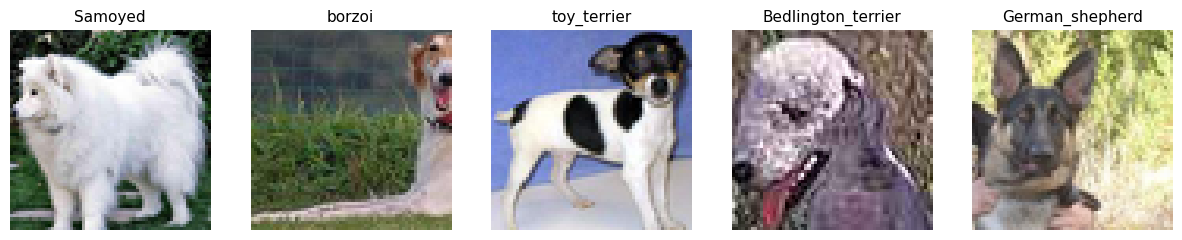

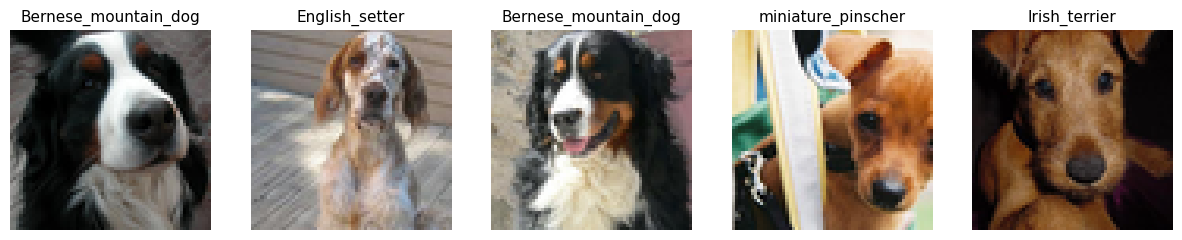

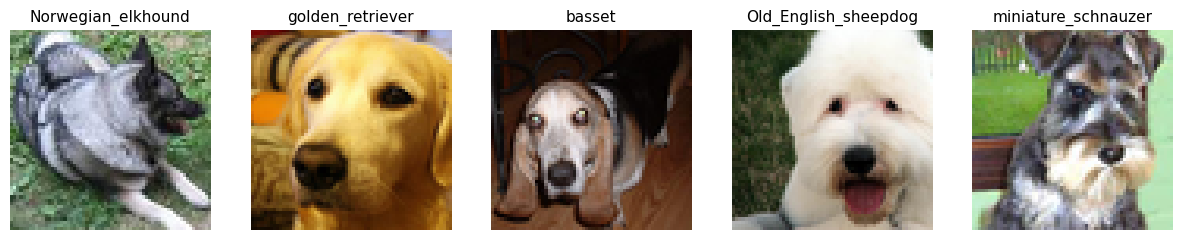

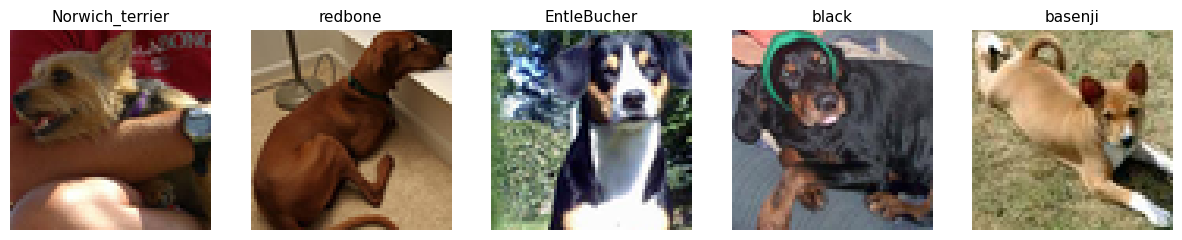

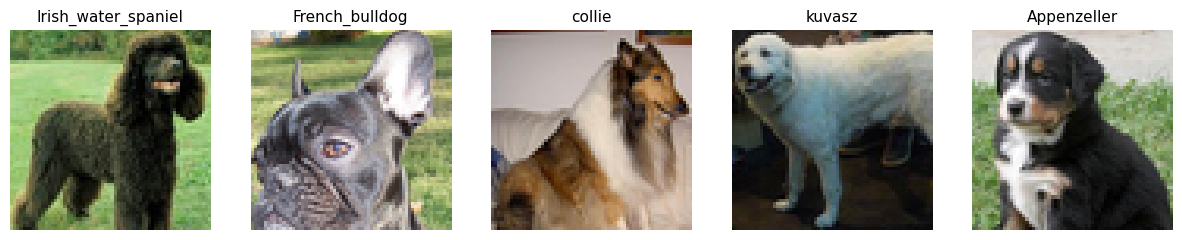

In [6]:
x = np.random.randint(0,idxIn,25)

for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

Getting random images shows that the the bounding boxes were kinda helpful. A good portion of the images are cropped or otherwise awkwark. Although that is part of the difficulty/genius of DL.
Had to use code from here to load in the images, the tensorflow tutorial was lacking
https://www.kaggle.com/code/cdeotte/supervised-generative-dog-net/notebook

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


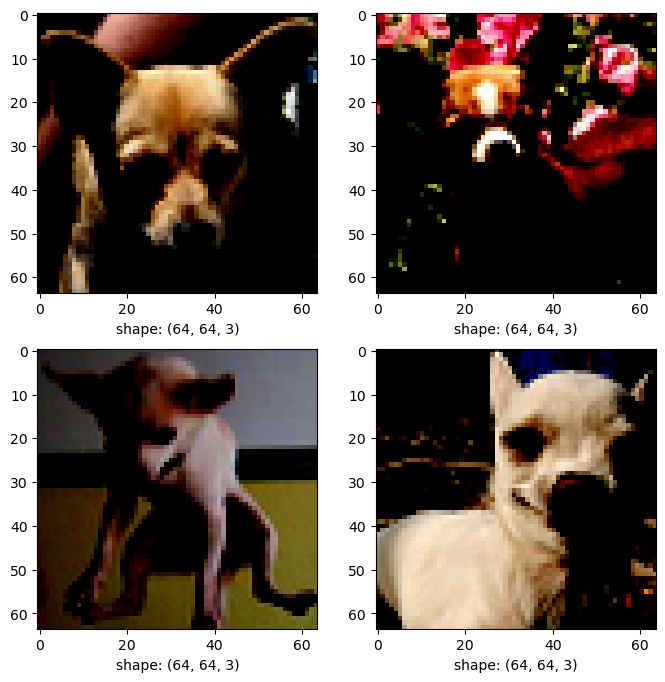

In [7]:
#Normalize the images
ImgNorm = (imagesIn[:idxIn,:,:,:]-127.5)/127.5
plt.figure(figsize=(8,8))
for image in range(4):
    plt.subplot(2,2, image+1)
    plt.imshow((ImgNorm[image]))
    plt.xlabel('shape: {}'.format(ImgNorm[image].shape))

In [8]:
ImgNorm = tf.cast(ImgNorm, 'float32')

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(ImgNorm).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
#dataset.shape()
print(dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


In [11]:
def make_generator():
    model1 = tf.keras.Sequential()
    model1.add(Dense(8*8*512, use_bias=False, input_shape=(100,)))

    model1.add(LeakyReLU())
    model1.add(Reshape((8, 8, 512)))
            

    model1.add(tf.keras.layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False,\
                kernel_initializer=WEIGHT_INIT))
   # model1.add(tf.keras.layers.BatchNormalization())
    model1.add(tf.keras.layers.LeakyReLU())
    model1.add(tf.keras.layers.Dropout(0.3))

    model1.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False,\
        kernel_initializer=WEIGHT_INIT))
    #model1.add(tf.keras.layers.BatchNormalization())
    model1.add(LeakyReLU())
    model1.add(Dropout(0.3))

    model1.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False,\
        kernel_initializer=WEIGHT_INIT))
    #model1.add(tf.keras.layers.BatchNormalization())
    model1.add(LeakyReLU())

    model1.add(Dense(3,activation='tanh', use_bias=False,\
        kernel_initializer=WEIGHT_INIT))

    return model1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3276800   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      3276800   
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 256)       0         
                                                        

/root/miniconda3/envs/ml_plugin/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 64, 64, 3)


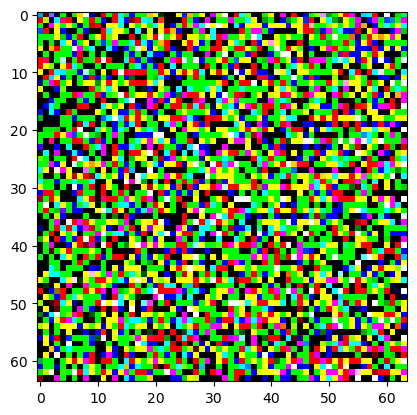

In [12]:
#init = RandomNormal(mean = 0.0, stddev = 0.02)
generator = make_generator()
print(generator.summary())
noise = tf.random.normal([1,100])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)

In [13]:
def make_discriminator():
    model2 = Sequential()
    model2.add(tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=[dim,dim,3],
                                      kernel_initializer=WEIGHT_INIT))
    #model2.add(tf.keras.layers.BatchNormalization())
    model2.add(tf.keras.layers.LeakyReLU())
    model2.add(tf.keras.layers.Dropout(0.3))
            
    model2.add(tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same',
                                     kernel_initializer=WEIGHT_INIT))
    #model2.add(tf.keras.layers.BatchNormalization())
    model2.add(tf.keras.layers.LeakyReLU())
    model2.add(tf.keras.layers.Dropout(0.3))
            
    model2.add(tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same',kernel_initializer=WEIGHT_INIT))
    #model2.add(tf.keras.layers.BatchNormalization())
    model2.add(tf.keras.layers.LeakyReLU())
    #model2.add(tf.keras.layers.Dropout(0.3))
    
    model2.add(tf.keras.layers.Flatten())
    model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model2

In [14]:
discriminator = make_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)        

In [15]:
decision = discriminator(generated_image)

In [16]:
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.3)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.5

def noisy_labels(y, p_flip):
    n_select = int(p_flip * y.shape[0].value)
    flip_ix = choice([i for i in range(y.shape[0].value)], size=n_select)
    [flip_ix] = 1 - y[flip_ix]
    return y

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
    fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))
    real_loss = cross_entropy(real_output_smooth, real_output)
    fake_loss = cross_entropy(fake_output_smooth, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [18]:
generator_optimizer = tf.keras.optimizers.Adam(.00002)
discriminator_optimizer = tf.keras.optimizers.Adam(.00002)

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
#@tf.function
def train_step(images, G_loss_list, D_loss_list):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1.)/2.)
        plt.axis('off')
    plt.show()


In [24]:
def train(dataset, epochs):
    G_loss = []
    D_loss = []
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch, G_loss, D_loss)

        G_loss = []
        D_loss = []
        if (epoch % 10 == 0):
            #print('test')
            display.clear_output(wait=True)
            generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print("Final Epoch")
    generate_and_save_images(generator,epochs,seed)

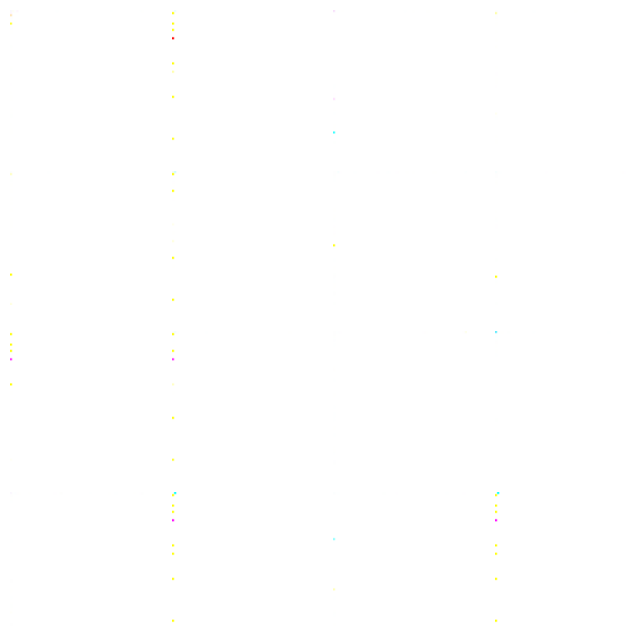

Time for epoch 191 is 103.62591767311096 sec
Time for epoch 192 is 103.40414762496948 sec
Time for epoch 193 is 103.15376925468445 sec
Time for epoch 194 is 103.27285528182983 sec
Time for epoch 195 is 103.91467046737671 sec
Time for epoch 196 is 102.96339797973633 sec
Time for epoch 197 is 104.51756477355957 sec
Time for epoch 198 is 104.04381012916565 sec
Time for epoch 199 is 103.5550045967102 sec
Time for epoch 200 is 102.95836234092712 sec
Final Epoch


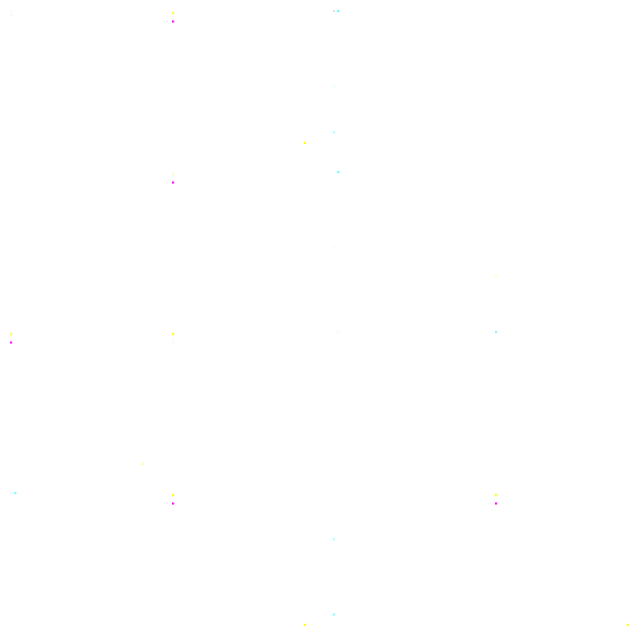

In [25]:
train(dataset, EPOCHS)

In [27]:
z = zipfile.PyZipFile('images.zip', mode='w')

for k in range(10000):
    generated_image = generator(tf.random.normal([1, noise_dim]), training=False)
    f = str(k)+'.png'
    img = ((generated_image[0,:,:,:]+1.)/2.).numpy()
    tf.keras.preprocessing.image.save_img(
        f,
        img,
        scale=True
    )
    z.write(f); os.remove(f)
z.close()

### Process and Conclusion
I had started out with following the tensorflow dcgan tutorial and I ran into 2 issues. The first I think would doom me early on. I kept running into hard crashes, as in my PC would shut down, no error no warning, nothing. I toyed with buffer sizes, batch sizes and a couple more arguments hoping it was related to memory usage as I've had issues like that with other projects but to no availe. I rolled back to a previous version and still nothing, so in the end I dissabled the GPU and went for CPU. 

For my first 'successful' build it was nothing but a series of colored squares like in the random normal generator. I had to disable several arguemnts because despite now running on a stable CPU build of tensorflow, the arguments would not run. After trying different arguments for those functions I ended up disabling them which I beleive hurt my model in the long run. However, at the time I had assumed that this was normal and because of my small buffer, batch and epoch settings from the first, now deleted run. So I bumped up all three and let the model run. It was interesting coming back every half hour and seeing the dynamics of the colored squares change, now you may have mistaken then for dead pixels on your screen because at this point all that is left is randomly placed pink pixels. I was hoping this was normal but as the hours rolled by and no even compressed abstractions of dogs rolled in my disapointment grew.

Despite many issues mentioned I haven't stated the second real issue, which is that this class has given me many problems, in fact this isn't my first time taking this class. Which wouldn't be a problem if it wasn't for this competition. When I first signed up for the competition I don't recall if the Monet competition was an option for this assignment, it may have been and I just prefered the dog option, but regardless I assumed since it was still an option for the assignment I stuck with the dogs. A mistake to be sure since although I had spent some time on it, what orignal code I had needed to be scrapped because of hardware issues, different than what I delt with now, and presumably more hours were spent on this than would have been required for the Monet competition. 

Excuses asside this has been my least favorite assignment, mostly my own fault for stuborness and hapless ignorence. My cancer detection project was a failure, accuracy as good as just guessing, but that was at least in the ball park and not some abandoned lot next to the park. With this I am not even sure where I went wrong, were those arguments I had to cut critical to building the model? Because it was executed on the CPU instead of a GPU have an impact? I am not sure. I am disapointed because 'AI images' are some of the coolest new tech and because I couldn't even get a brown blur dissapoints me greatly.

https://www.kaggle.com/code/cmalla94/dcgan-generating-dog-images-with-tensorflow/notebook
I have to give credit to this post because I had to rely on it for way more than I care to admit, but as you can see I couldn't even get anything close to their results. 

I will upload one of the first pass generated images I mentioned above to the kaggle score submission window to see where it started and had hope would improve and not just result in a pink pixel.